In [1]:
#Projet

## Question 1

*Approximate the integral of f using standard Monte Carlo and quasi-Monte Carlo,
and compare the results, for different values of d (and different Monte Carlo sample
sizes!).*

**A. Monte-Carlo standard**

In [2]:
#!pip install qmcpy

In [3]:
import time
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats.qmc import Sobol

In [4]:
#Fonction target

def f(u):
    d = u.shape[1] 
    return 1 + np.sin(2 * np.pi * (1/d * np.sum(u, axis = 1) - 1/2))

def f2D(u,v):
    d = 2
    return 1 + np.sin(2 * np.pi * (1/d * (u+v) - 1/2))

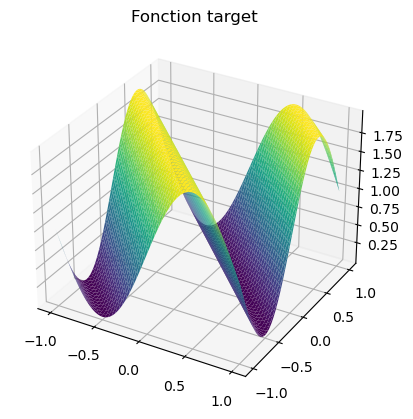

In [27]:
#Visualisation de la fonction target en 3D (pour d = 2)
x1 = np.linspace(-1, 1, num=100)
x2 = np.linspace(-1, 1, num=100)
X1, X2 = np.meshgrid(x1, x2)
Z = f2D(X1, X2)
fig = plt.figure()
ax = fig.add_subplot(projection='3d') # pour un graphe en 3D
ax.plot_surface(X1, X2, Z, cmap='viridis')
plt.title("Fonction target")
plt.show()


In [30]:
#Estimation de l'intégrale par la méthode de Monte Carlo standard

def MonteCarlo(f,d,N):
    x = np.random.rand(N, d)   #génération de points aléatoires (uniformes)
    integral = np.sum(f(x))/N  #approximation de l'intégrale
    return(integral)

In [31]:
MonteCarlo(f, N = 100000, d = 3)

1.0003958232120427

**B. Quasi Monte-Carlo**

In [32]:
#Estimation de l'intégrale par la méthode de Quasi Monte Carlo 

def QuasiMonteCarlo(f, d, N):
    sobol = Sobol(d)              #génération des points quasi-aléatoires avec la méthode Sobol
    u = sobol.random(n = N)       #génération des points quasi-aléatoires
    integral = np.sum(f(u)) / N   #calcul de l'intégrale approximative
    return(integral)

QuasiMonteCarlo(f, N = 100000, d = 3)

/opt/mamba/lib/python3.10/site-packages/scipy/stats/_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


0.9999956635020494

**C. Comparaison**

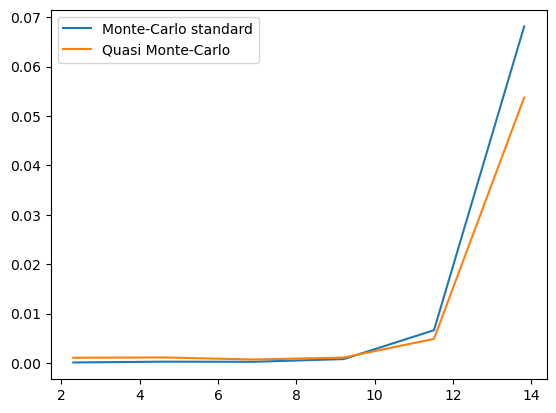

In [9]:
#Temps de calcul
NN = np.array([10, 100, 1000, 10000, 100000, 1000000])

tempsMCstandard = []
tempsQMC = []

for n in NN :
    start_time = time.time()
    MonteCarlo(f, N = n, d = 3) #Appel de la fonction
    end_time = time.time()
    tempsMCstandard.append(end_time - start_time)
    
    start_time = time.time()
    QuasiMonteCarlo(f, N = n, d = 3) #Appel de la fonction
    end_time = time.time()
    tempsQMC.append(end_time - start_time)

plt.plot(np.log(NN),tempsMCstandard)
plt.plot(np.log(NN),tempsQMC)
plt.legend(['Monte-Carlo standard', 'Quasi Monte-Carlo'])


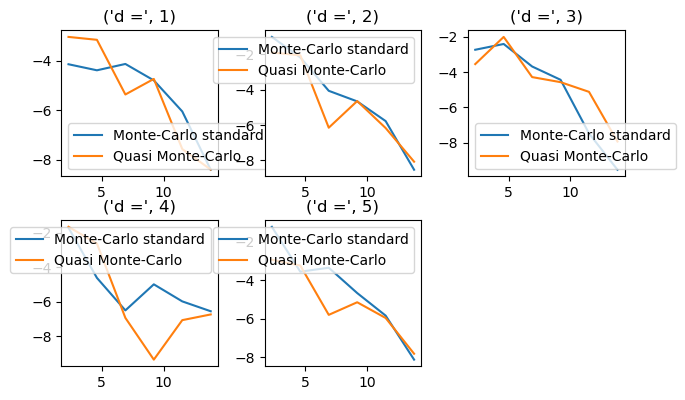

In [10]:
#Précision
NN = np.array([10, 100, 1000, 10000, 100000, 1000000])
DD = np.arange(1,6)

l = 1
for d in DD:
    precisionMCstandard = []
    precisionQMC = []
    for n in NN :
        y_predict = MonteCarlo(f, N = n, d = d) #Appel de la fonction
        precisionMCstandard.append(np.abs(1-y_predict))

        y_predict = MonteCarlo(f, N = n, d = d) #Appel de la fonction
        precisionQMC.append(np.abs(1-y_predict))
    
    plt.subplot(2,3,l)
    plt.plot(np.log(NN),np.log(precisionMCstandard))
    plt.plot(np.log(NN),np.log(precisionQMC))
    plt.legend(['Monte-Carlo standard', 'Quasi Monte-Carlo'])
    plt.title(('d =', d))
    l+=1

plt.gcf().subplots_adjust(left = 0.02, bottom = 0.2, right = 0.9, top = 0.9, wspace = 0.3, hspace = 0.3)
#plt.figure(figsize = (20, 10))

In [11]:
#comparaisons à améliorer

## Question 2

*Read the introduction of the following paper https://arxiv.org/abs/2210.01554
up to Equations (5) and (6), which introduce Haber’s estimators of order 1 and
2. Implement these two estimators, and compare to the results of Step 1. (Again
consider different values of d and N, where N is the number of evalations of f).*

In [12]:
import numpy as np
from scipy.integrate import nquad
from scipy.stats import uniform

In [13]:
#methode 1 (fonctions python)

def cells_centers(f, d = 2, n_cells = 5):
    cell_size = [1/n_cells]*d
    grid = np.meshgrid(*[np.linspace(cell_size[1]/2, 1 - cell_size[0]/2, n_cells)]*d)
    #calcul des coordonnées des centres de chaque cellule
    cell_coord = np.array([g.ravel() for g in grid]).T
    #évaluation de la fonction f en chaque centre c
    return(cell_coord)

#methode 2 (plus manuelle)

from itertools import product
def cells_centers_2(f, d = 2, n_cells = 5):
    #calcul des coordonnées des centres de chaque cellule
    vecteur = np.around(np.linspace(1/(2*n_cells), 1 - 1/(2*n_cells), n_cells), decimals=10)
    cell_coord = product(vecteur, repeat = d) #product donne toutes les combinaisons possibles de groupes de taille d du vecteur en argument 
    cell_coord = np.array(list(map(list, cell_coord))) #changement de type
    return(cell_coord) #évaluation de la fonction f en chaque centre c


In [14]:
def g_c(x,c):
    return((f(c + x) + f(c - x))/2)

In [15]:
def habers_estimation(f, cell_coord, order = 1, k = 1000, d = 2):
    # Générer les matrices de déplacements aléatoires
    U = np.random.uniform(low=-1/(2*k), high=1/(2*k), size=(len(cell_coord), d))
    # Évaluer f aux centres de chaque hypercube déplacé
    if order == 1:
        f_values = f(cell_coord + U)
    if order == 2:
        f_values = g_c(U, cell_coord)
    # Calculer l'estimation d'Haber
    return np.mean(f_values, axis=0)
    

In [16]:
cell_coord = cells_centers_2(f,d = 2, n_cells = 5)
habers_estimation(f, cell_coord, order = 1)

0.9998960215298086

In [17]:
habers_estimation(f, cell_coord, order = 2)

1.0000001150575806

**A. Harber's Estimators**

In [18]:
# Haber's Estimator selon ChatGPT, j'ai pas tout tout compris mais ça sort des trucs sympas...
from scipy.stats import uniform

def HaberEstimators(func, d, k, order=1):
    N = k * d 
    Uc = uniform.rvs(size=(N, d), loc=-1/(2*k), scale=1/k)
    Ck = [np.array([i/k for _ in range(d)]) for i in range(k)]

    if order == 1:
        f_values = [func(np.expand_dims(c + uc, axis=0)) for c, uc in zip(Ck, Uc)]
        return np.mean(f_values)
    elif order == 2:
        f_values = [0.5 * (func(np.expand_dims(c + uc, axis=0)) + func(np.expand_dims(c - uc, axis=0))) for c, uc in zip(Ck, Uc)]
        return np.mean(f_values)

In [19]:
HaberEstimators(f, d = 3, k = 100, order=1)

0.9998697299989804

In [20]:
HaberEstimators(f, d = 3, k = 100, order=2)

0.9999970070660359

**B. Comparaison**

In [21]:
# Comparaison des méthodes... (on préfere Haber d'ordre 2 quand f est 2 fois continuement différentiable)
ds = [1, 2, 3]
k_values = [10, 50, 100]

for d in ds:
    for k in k_values:
        N = d * k
        mc_result = MonteCarlo(f, d, N)
        qmc_result = QuasiMonteCarlo(f, d, N)
        haber1_result = HaberEstimators(f, d, k, order=1)
        haber2_result = HaberEstimators(f, d, k, order=2)

        print(f"d = {d}, N = {N}")
        print(f"Standard Monte Carlo: {mc_result}")
        print(f"Quasi-Monte Carlo: {qmc_result}")
        print(f"Haber's estimator of order 1: {haber1_result}")
        print(f"Haber's estimator of order 2: {haber2_result}")
        print("\n")

d = 1, N = 10
Standard Monte Carlo: 1.0622442068372915
Quasi-Monte Carlo: 1.0035787445971671
Haber's estimator of order 1: 1.0039145495035522
Haber's estimator of order 2: 0.9922006371456134


d = 1, N = 50
Standard Monte Carlo: 1.0275492178502708
Quasi-Monte Carlo: 1.0054693221033848
Haber's estimator of order 1: 1.0012565154834028
Haber's estimator of order 2: 1.000067293890391


d = 1, N = 100
Standard Monte Carlo: 0.9900034114673721
Quasi-Monte Carlo: 1.0115624778224166
Haber's estimator of order 1: 1.0002687538073247
Haber's estimator of order 2: 1.0000001949730595


d = 2, N = 20
Standard Monte Carlo: 0.9322763110453142
Quasi-Monte Carlo: 1.0536711252469657
Haber's estimator of order 1: 1.019461343281303
Haber's estimator of order 2: 0.9991713016009136


d = 2, N = 100
Standard Monte Carlo: 1.0564684641871593
Quasi-Monte Carlo: 1.0001842948243604
Haber's estimator of order 1: 1.0032785065327559
Haber's estimator of order 2: 0.9999644499660054


d = 2, N = 200
Standard Monte Carlo

## Question bonus

*Bonus: try to think of an importance sampling approach to obtain a better estimate
of this integral.*

Une distribution d'importance sampling appropriée pour cette fonction f est une distribution qui est proche de la fonction f et qui permet de minimiser la variance de l'estimateur de Monte Carlo.

In [33]:
#définition de la fonction g (densité que l'on sait simuler facilement)
import scipy.stats as stats
def g(u):
    return(np.all(u >= 0, axis = 1)*np.all(u <= 1, axis = 1))

u = np.random.uniform(low=-1, high=1, size=(10, 2))

def g2D(u,v):
    return((u>=0)*(v>=0)*(u<=1)*(v<=1))


Text(0.5, 0.92, 'densité uniforme')

<Figure size 640x480 with 0 Axes>

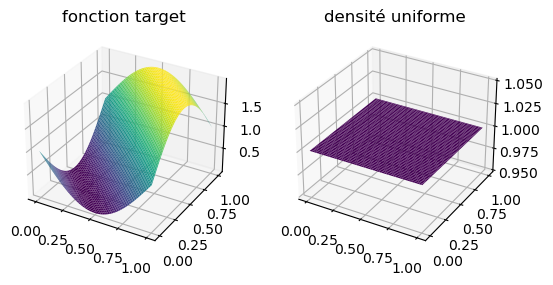

<Figure size 640x480 with 0 Axes>

In [34]:
#visualisation des 2 densités
x1 = np.linspace(0, 1, num=100)
x2 = np.linspace(0, 1, num=100)
X1, X2 = np.meshgrid(x1, x2)
Z = f2D(X1, X2)
fig = plt.figure()
fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'projection': '3d'})
ax1.plot_surface(X1, X2, Z, cmap='viridis')
ax1.set_title('fonction target')

x1 = np.linspace(0, 1, num=100)
x2 = np.linspace(0, 1, num=100)
X1, X2 = np.meshgrid(x1, x2)
Z = g2D(X1, X2)
fig = plt.figure()
ax2.plot_surface(X1, X2, Z, cmap='viridis')
ax2.set_title('densité uniforme')

In [25]:
from scipy.stats import multivariate_normal
def importance_sampling(f, g, N, d):
    mu = np.array([1/2]*d)
    sigma = np.eye(d)
    u = np.random.uniform(low=0, high=1, size=(N, d))
    weights = f(u)/g(u)
    integral = np.sum(weights)/N
    #error = np.sqrt(np.var(weights) / n_samples)
    return integral

importance_sampling(f, g, N = 100000000, d = 2)


0.9999209991353006

**à faire :**
- essayer de comprendre la fonction chatGPT de diego
- faire des graphes pour les comparaisons (+ comparer aussi le temps de calcul)
- vérifier que les conditions du papier soient remplies pour ces estimateurs (f appartient à C^r([0,1]^s)
- réfléchir au bonus
- séparer les fonctions en de plus petites fonctions